In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import IPython
from scipy.io import wavfile

## Non adaptive, non iterative approach

We compute the optimal filter $\bold{f}$ by naively solving the normal equations $R_X \bold{f} = \bold{r_{DX}}$. This is far from optimal because it is a slow method and it is not adaptive.

#### Read audio files

In [81]:
# Normalization by 2^15 - 1 is necessary
fs_d, d = wavfile.read('data/2_RecStatic.wav')  # read d[n]
d_normalized = d / 32767

_, x = wavfile.read('data/2_Sig.wav')  # read x[n]
x_normalized = x / 32767

In [66]:
IPython.display.Audio(d, rate=fs_d)

In [67]:
IPython.display.Audio(x, rate=fs_d)

### Compute correlation matrices and optimal filter

In [68]:
K = 800  # Number of taps

# Compute correlations
Rx = np.zeros(K)
rdx = np.zeros(K)

for i in range(K):
    # Rx[i] = np.mean(x[:-K] * x[i:i+len(x)-K])
    Rx[i] = np.mean(x_normalized[:(len(x)-K)] * x_normalized[i:(len(x) + i - K)])
    rdx[i] = np.mean(x_normalized[:(len(x)-K)] * d_normalized[i:(len(x) + i - K)])

# can also use sp.correlate

R = sp.linalg.toeplitz(Rx)

In [69]:
# Compute "adaptive" filter
f = np.linalg.solve(R, rdx)

### Apply filter, plot results

In [ ]:
# Use filter to substract echo
e = d_normalized - np.convolve(x_normalized, f)[0:len(d_normalized)]

In [71]:
IPython.display.Audio(d, rate=fs_d)

In [72]:
IPython.display.Audio(x, rate=fs_d)

In [73]:
IPython.display.Audio(e, rate=fs_d)

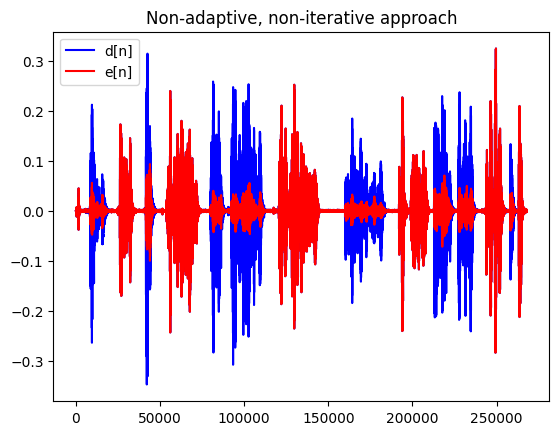

In [94]:
plt.title('Non-adaptive, non-iterative approach')
plt.plot(d_normalized, color='blue', label='d[n]')
plt.plot(e, color='red', label='e[n]')
plt.legend()

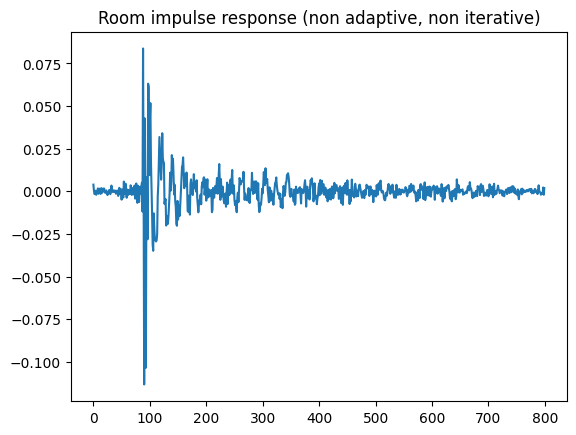

In [75]:
plt.title('Room impulse response (non adaptive, non iterative)')
plt.plot(f)

### Non adaptive, iterative method

Instead of solving the normal equations directly, we solve them using an iteration. The optimal filter is given by the iteration $\bold{f}^{(i+1)} = \bold{f}^{(i)} + \mu \bold{p}$ where $\bold{p}$ is an update direction and $0 < \mu < \frac{2}{\lambda_{\text{max}}}$ is the step size. This iteration approximates the solution of $R_X \bold{f} = \bold{r_{DX}}$. This method is not fundamentally different than the previous one.

#### Compute step size

In [90]:
K = 800  # number of taps
N_it = 500  # number of iterations

# TODO: recompute R here
eigenvalues, _ = np.linalg.eig(R)
lambda_max = np.max(eigenvalues)
lambda_min = np.min(eigenvalues)

mu = 2/(lambda_max + lambda_min)

if mu >= 2/lambda_max:
    print("Step size cannot be bigger than 2/lambda_max!")

### Iteration

In [91]:
f_it = np.zeros(K)

for i in range(N_it):
    f_it = f_it + mu * (rdx - R @ f_it)

### Apply filter, plot results

In [92]:
e_it = d_normalized - np.convolve(x_normalized, f_it)[0:len(d_normalized)]

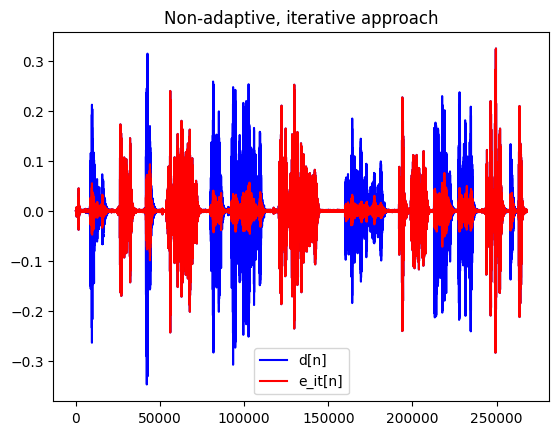

In [95]:
plt.title('Non-adaptive, iterative approach')
plt.plot(d_normalized, color='blue', label='d[n]')
plt.plot(e_it, color='red', label='e_it[n]')
plt.legend()

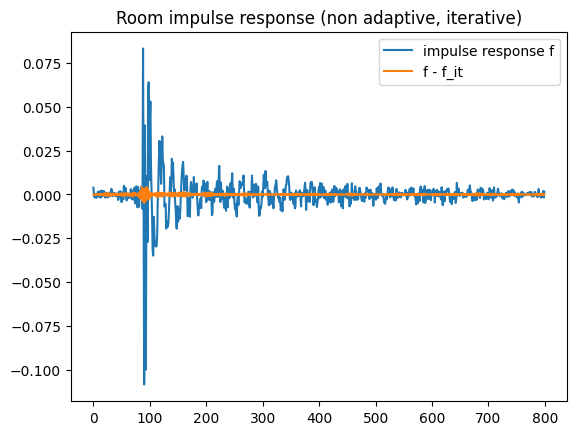

In [98]:
plt.title('Room impulse response (non adaptive, iterative)')
plt.plot(f_it, label='impulse response f')
plt.plot(f - f_it, label='f - f_it') # ideally it is very small
plt.legend()

## Adaptive Least Mean Squares (LMS)

This method uses the LMS algorithm, which iteratively computes $\bold{f}_{n+1} = \bold{f}_n + \mu \bold{x}_n e_n$, where $e_n = d_n - y_n$. It is much faster than the previous naive method and can be used to compute $\bold{f}_n$ on the fly.

In [28]:
# Compute lambda max, choose 0 < mu < 2/lambdaMax

In [30]:
# Apply the iteration (cf other notebooks)